# Importing the required libraries


In [45]:
# import statements
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm.notebook import tqdm
from yellowbrick.classifier import ClassificationReport
from texttable import Texttable
from pytorch_lightning import Trainer
import warnings  # ignore any warnings
warnings.filterwarnings("ignore")

# Training Dataset Creation

Loading the dataset from the directory

In [46]:
def load_dataset(directory_path):  # load dataset 
  image_transforms = transforms.Compose(
                    [transforms.Resize((32,32)), # resize images
                     transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalization of images
                    ])
  
  dataset = ImageFolder(    # root path of the data set folder
                        root = directory_path,
                        transform = image_transforms # to transform the images
                        )
  return dataset

directory_path = "./AI Dataset/data/" # path directory
dataset = load_dataset(directory_path)  # load dataset from the given directory

Dataset classes/labels

In [47]:
classes = dataset.classes  # prints the no. of classes i.e. labels we have in the dataset
classes

['not_a_person', 'with_mask', 'without_mask']

Counting the number of images present in each of the classes

In [5]:
 def data_class_distribution(dataset):  # gives the count of each classes of the dataset i.e. no of images per class
  data_class_count = {}
  for _, index in dataset:
    label = classes[index]
    if label not in data_class_count:
      data_class_count[label] = 0
    data_class_count[label] += 1
  return data_class_count  # returns the count
    
 data_class_count = data_class_distribution(dataset)
 print("The number of images present in each of the three classes:", data_class_count) # print count of classes

The number of images present in each of the three classes: {'not_a_person': 6000, 'with_mask': 6027, 'without_mask': 5978}


# Dataset Visualization

In [6]:
def plot_dataset_images(file_path, images_list):  # method to visualise our dataset, for the passed parameter class
  rows=5    # no. of rows for images to plot
  cols=5    # no. of column for images to plot

  fig,ax = plt.subplots(rows,cols,figsize=(25,100))
  r = 0
  c = 0
  for i in range(rows*cols):
    aa = plt.imread(os.path.join(file_path, images_list[i]))
    ax[r,c].axis("off")
    ax[r,c].imshow(aa)
    c+=1
    if c == cols:
      c=0
      r+=1
  plt.show() # plotting of the images

1. Sample images of the class "With a mask"

In [7]:
with_mask_file_path = "./AI Dataset/data/with_mask" # to plot with mask images dataset
with_mask_images = os.listdir("./AI Dataset/data/with_mask") 

plot_dataset_images(with_mask_file_path, with_mask_images)

2. Sample images of the class "Without a mask"

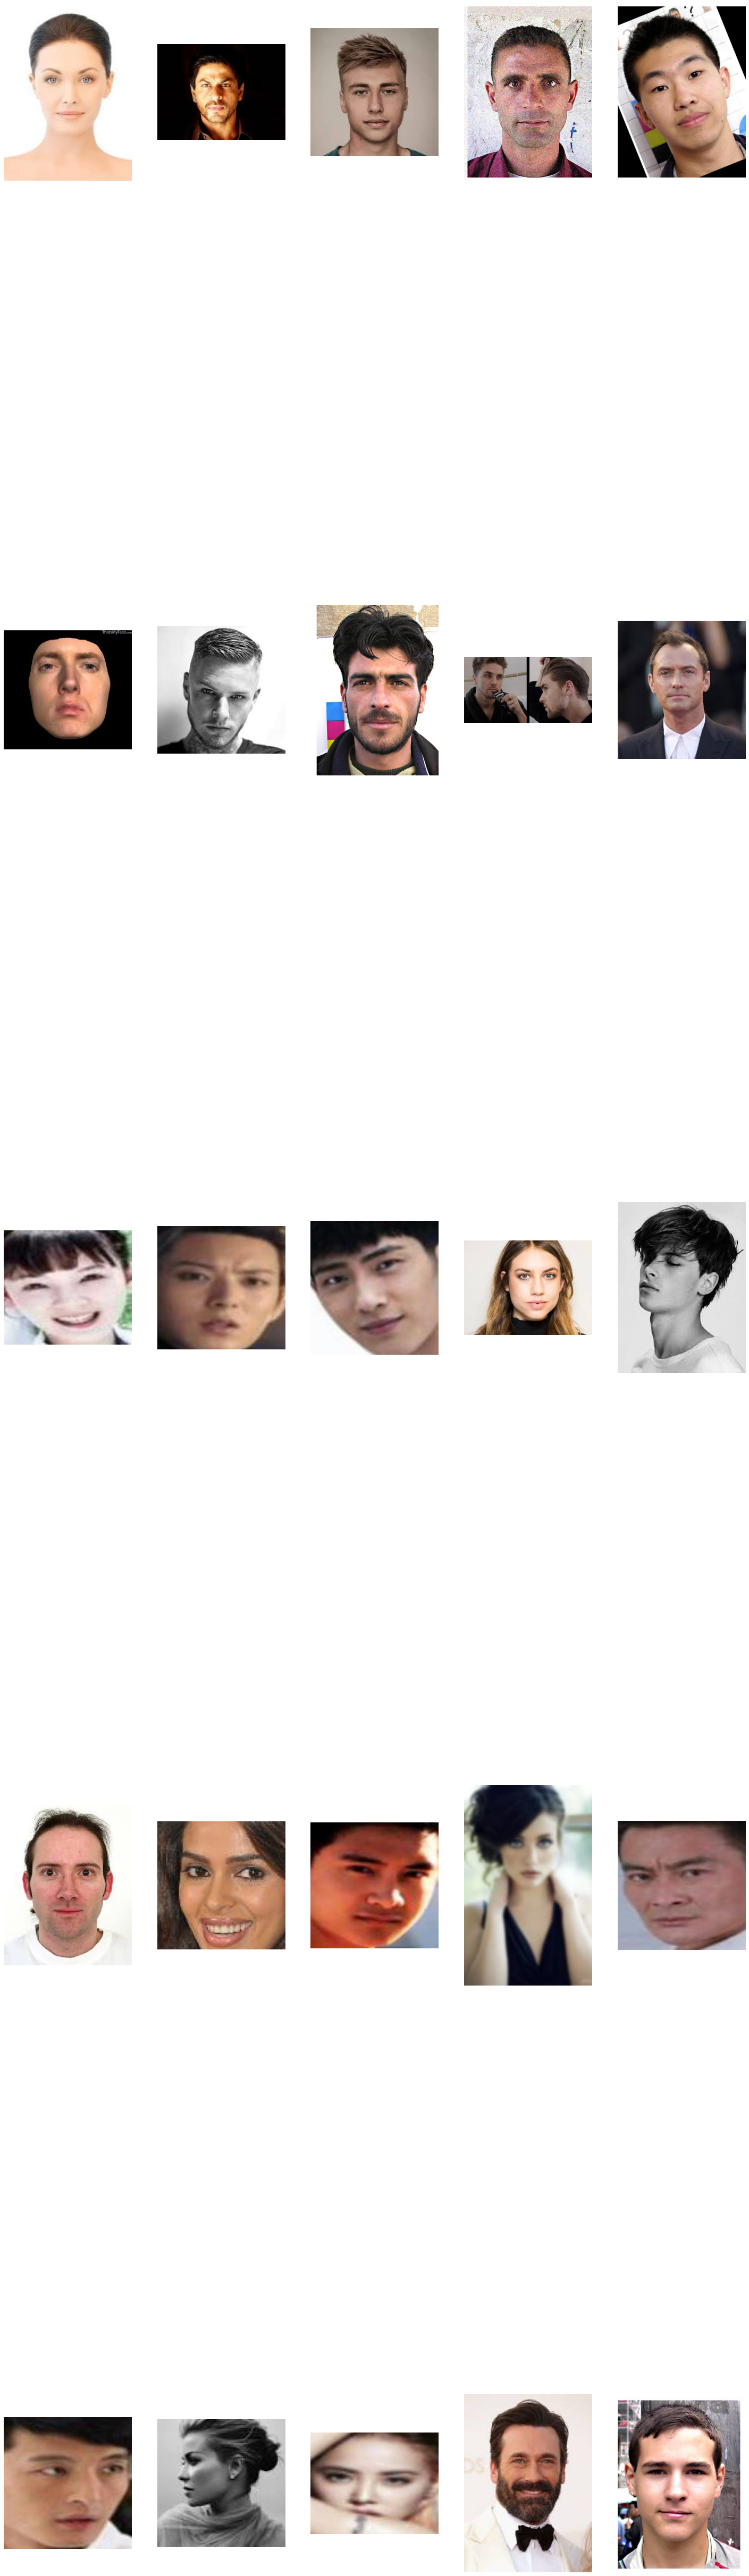

In [8]:
without_mask_file_path = "./AI Dataset/data/without_mask"  # to plot without mask images dataset
without_mask_images = os.listdir("./AI Dataset/data/without_mask")

plot_dataset_images(without_mask_file_path, without_mask_images)

3. Sample images of the class "Not a person"

In [9]:
not_a_person_file_path = "./AI Dataset/data/not_a_person"  # to plot not a person images dataset
not_a_person_images = os.listdir("./AI Dataset/data/not_a_person")

plot_dataset_images(not_a_person_file_path, not_a_person_images)

Categorical representation of the datasets

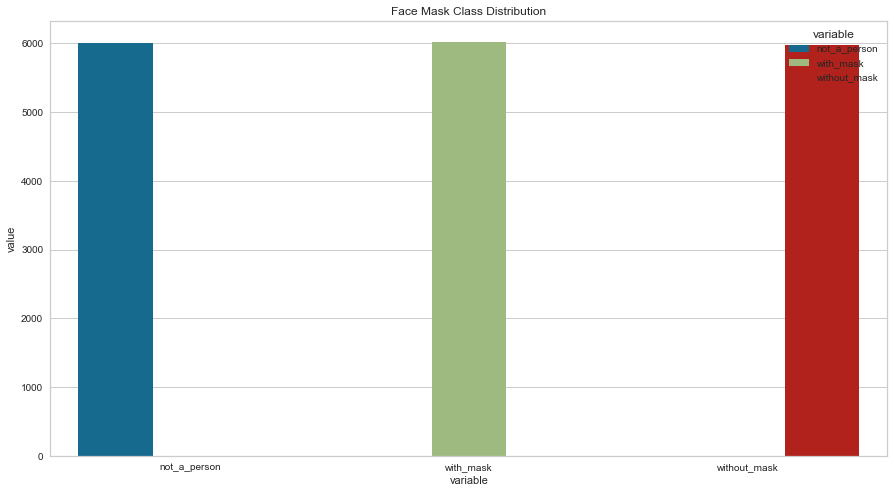

In [10]:
plt.figure(figsize=(15,8))  # plots the distribution of each class images
sns.barplot(data = pd.DataFrame.from_dict([data_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
plt.show()

Splitting the Data into train, validation and test sets
1. Train size - 80% of the total dataset images
2. Test size - 10% of the total dataset images
3. Validation size - 10% of the total dataset images

In [48]:
train_size = int(0.8 * len(dataset))   
test_size = round((len(dataset) - train_size) * 0.5)   # random split of the datasets
train_dataset, val_dataset, test_dataset = random_split(dataset, (train_size, test_size, test_size+1))

# Loading Data with the help of DataLoader

In [49]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=4, num_workers=2)  # loading train dataset
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=4, num_workers=2) # loading validation dataset
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size = 1801) # loading test dataset
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

Length of the train_loader: 3601
Length of the val_loader: 450
Length of the test_loader: 1


# Convolutional Neural Network Architecture and model training

CNN Model Architecture
- Consist of three major blocks in the CNN Model

In [93]:
class CNN(nn.Module):  # CNN Model class
 
  def __init__(self):
    super(CNN, self).__init__()    # blocks architecture
    self.conv_layer = nn.Sequential(   
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # block 1
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # block 2
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # block 3
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fully_connected_layer = nn.Sequential(  # full connected layer
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 32, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(128, 3)
    )

  def forward(self, x):   # forward pass on the CNN Model
    
    x = self.conv_layer(x) # convolutional layers

   
    x = x.view(x.size(0), -1)  # flattening the layers

    
    x = self.fully_connected_layer(x) # fully connected layer

    return x

CNN model, loss function and Optimizer initialization


In [94]:
net = CNN()  # calling Model 
criterion = nn.CrossEntropyLoss()  # loss criteria
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # using Stochastic Gradient Descent as a optimizer
# lrf = LearningRateFinder(net, criterion, optimizer)  # to find the best learning rate on the model
# lrf.fit(train_loader)
# lrf.plot() # plot the best learning rate 


#Training the CNN model

Conversion of output probabilities to predicted class labels

In [95]:
def images_to_probs(net, images):  # to predict the class labels 
    output = net(images)
    _, preds_tensor = torch.max(output, 1)  
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

Evaluation function 


In [96]:
def evaluate_accuracy(net, dataloader):  # method to evaluate the accuracy of the passed dataset
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)   # counting total no. of dataset
            correct += (preds == labels).sum()  # counting correct predictions done by the model
    return correct/total * 100

Train CNN Model for the given Parameters



In [97]:
def train_model(net,  criterion, opt, dataloader, epochs):  # train model based on the given parameter
    num_steps = 0  
    min_loss = 1e+10
    running_loss = []  # to store the loss of each epochs 
    epochs_loss = []
    accuracy = []  # to store the accuracy of each epochs
    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            
            outs = net(images)   # Forward Propagation on the Model
            loss =  criterion(outs, labels)

            
            running_loss.append(loss.item()) # Storing loss values

           # Backward Propagation on the Model
            opt.zero_grad()   
            loss.backward()
            opt.step()

        
        epoch_loss = sum(running_loss) / len(running_loss) # calculating loss for each epoch
        epochs_loss.append(epoch_loss)
        acc = evaluate_accuracy(net, dataloader) # calculating the accuracy for each epoch
        accuracy.append(acc)
        print("Accuracy of the Model in epoch {} : {}".format(num_steps, acc)) 
        print("Loss of the current epoch: ",epoch_loss)
        
        if epoch_loss < min_loss:  # Finding the minimum loss
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    return running_loss, epochs_loss, accuracy

    print('Training finished on the Train data-sets!!!')

In [98]:
num_epochs = 20   # define no. of epochs to run
running_loss,epochs_loss,accuracy = train_model(net, criterion, optimizer, train_loader, num_epochs)  # train dataset


Accuracy of the Model in epoch 3601 : 91.24548736462094
Loss of the current epoch:  0.45394888548192097
Accuracy of the Model in epoch 7202 : 94.89725076367675
Loss of the current epoch:  0.34973574900946386
Accuracy of the Model in epoch 10803 : 96.13996112191057
Loss of the current epoch:  0.29078161023635646
Accuracy of the Model in epoch 14404 : 97.28547625659539
Loss of the current epoch:  0.2518590104314597
Accuracy of the Model in epoch 18005 : 97.19522354901416
Loss of the current epoch:  0.22175571326501967
Accuracy of the Model in epoch 21606 : 97.590946959178
Loss of the current epoch:  0.1991314103887323
Accuracy of the Model in epoch 25207 : 98.80588725354067
Loss of the current epoch:  0.18008321790370896
Accuracy of the Model in epoch 28808 : 98.21577339627882
Loss of the current epoch:  0.1636890946191957
Accuracy of the Model in epoch 32409 : 99.13912801999444
Loss of the current epoch:  0.15003659856872875
Accuracy of the Model in epoch 36010 : 98.78505970563732
Loss 

Training Loss Plot

[0.45394888548192097, 0.34973574900946386, 0.29078161023635646, 0.2518590104314597, 0.22175571326501967, 0.1991314103887323, 0.18008321790370896, 0.1636890946191957, 0.15003659856872875, 0.13888623037654096, 0.12863760978343408, 0.12008749066310453, 0.1121932322265693, 0.10571404401375017, 0.09960928363172976, 0.09432960323826596, 0.08966642612019192, 0.08511783670696794, 0.0812488888173788, 0.07760815856141856]


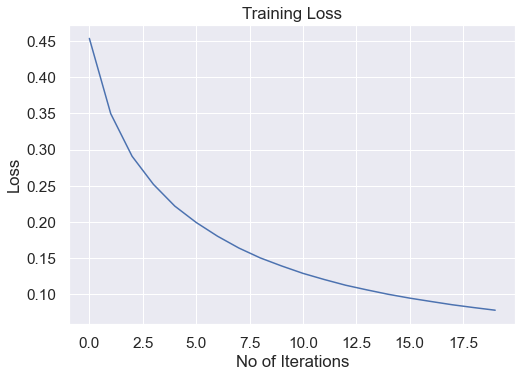

In [101]:
print(epochs_loss)
plt.plot(epochs_loss, label='Training loss') # print loss of each epoch
plt.title("Training Loss")
plt.xlabel("No of Iterations")
plt.ylabel("Loss");

Training Accuracy Plot

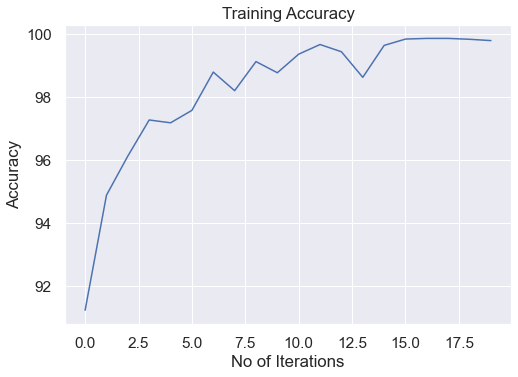

In [102]:
plt.plot(accuracy, label="Training Accuracy") # print accuracy of each epoch
plt.title("Training Accuracy")
plt.xlabel("No of Iterations")
plt.ylabel("Accuracy");

# Validating Network

Prediction of the Images


In [103]:
def prediction(predlab, testlab):  # method to show comparsion between Actual vs Predicted
  print("Prediction vs Actual class Label")
  predicted_list = []
  actual_list = []
  for i in predlab:
    if i == 0:  
      predicted_list.append("without_mask")
    elif i ==1: 
      predicted_list.append("with_mask")
    else :
      predicted_list.append("not_a_person")
 
  for i in testlab:
    if i == 0:  
      actual_list.append("without_mask")
    elif i ==1:
      actual_list.append("with_mask")
    else :
      actual_list.append("not_a_person")
        
  t = Texttable()
  main_row = [['Predicted', 'Actual']]

  for i in range(0, len(predicted_list)):
    tmp = [predicted_list[i],actual_list[i]]
    main_row.append(tmp)
  t.add_rows(main_row)
  print(t.draw()) # printing the talbe

In [104]:
acc = evaluate_accuracy(net, val_loader)   # evaluate the accuracy on the validation set
print("Accuracy of the Model on Test set: ",acc)
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)  

prediction(predlab, testlab) # predictions of the validation set

Accuracy of the Model on Test set:  97.66666666666667
Prediction vs Actual class Label
+--------------+--------------+
|  Predicted   |    Actual    |
+==============+==============+
| not_a_person | not_a_person |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| not_a_person | not_a_person |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+


# Testing Network



In [105]:
acc = evaluate_accuracy(net, test_loader)  # evaluate the accuracy on the test set
print("Accuracy of the Model on Test set: ",acc)
testimg, testlab = next(iter(test_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)
prediction(predlab[0:10], testlab[0:10]) # predictions of the first 10 test set


Accuracy of the Model on Test set:  97.55691282620766
Prediction vs Actual class Label
+--------------+--------------+
|  Predicted   |    Actual    |
+==============+==============+
| not_a_person | not_a_person |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| not_a_person | not_a_person |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+
| with_mask    | with_mask    |
+--------------+--------------+
| without_mask | without_mask |
+--------------+--------------+


# Convolutional Neural Network Model Evaluation
1. Confustion Matrix
2. Precision
3. Recall
4. Accuracy
5. F1-Score

# Confusion Matrix

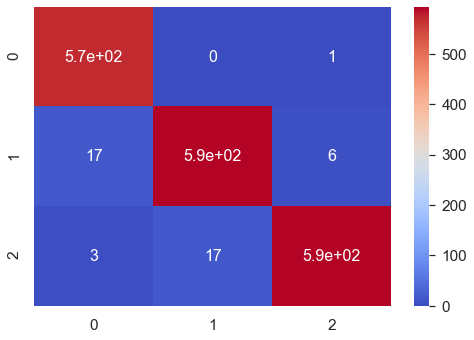

[[572   0   1]
 [ 17 593   6]
 [  3  17 592]]


In [106]:
pred = predlab.numpy()   # plot the confusion matrix 
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
sns.set(font_scale=1.4) # for label size
sns.heatmap(matrix, annot=True, annot_kws={"size": 16},cmap="coolwarm")  # use of heatmap
plt.show()  # plot confusion matrix
print(matrix)


# Classification Report

In [110]:
report = classification_report(test, pred, target_names=['with_mask','without_mask','not_a_person'])
print(report)  

              precision    recall  f1-score   support

   with_mask       0.97      1.00      0.98       573
without_mask       0.97      0.96      0.97       616
not_a_person       0.99      0.97      0.98       612

    accuracy                           0.98      1801
   macro avg       0.98      0.98      0.98      1801
weighted avg       0.98      0.98      0.98      1801

